# EV353 Problem Set 3 - Coupled Climate Variability and Buoyancy Forcing 
### Part 2: Python Data Analysis

### Overview

Ocean-atmosphere interactions give rise to many flavors of natural climate variability that have significant impacts on society, including freshwater resources, human health, and hurricane activity. The ocean’s density-driven thermohaline circulation also helps shape global climate, particularly on longer timescales ranging from decades to millennia.

In this problem set, you will demonstrate both your qualitative and quantitative understanding of the mechanisms by which the ocean and atmosphere influence each other and how the ocean responds to buoyancy forcing. Your responses should incorporate the concepts covered in class and the assigned readings. Chapters 6.3, 7 and 8 in Physical Oceanography and Climate by Kris Karnauskas and this week’s scientific papers will be helpful references. 

**To foster a collaborative learning environment, you will complete this lab with a partner.** The pairings will be randomly determined in class and posted on Canvas. Each person is required to complete and contribute to all questions. This includes conducting all calculations/analyses and writing your own code. *It is against the honor code to divide up the questions among different individuals or use generative AI/chatbots on any aspect this assignment. All answers must be written in your own words.*


### Learning Outcomes

After completing this assignment, you will be able to:
- Describe the mechanisms by which the ocean and atmosphere influence each other to yield modes of natural climate variability. Here focusing on the El Niño-Southern Oscillation (ENSO).
- Characterize observed ENSO variability using real-world observations.
- Compare and contrast the dominant physical processes leading to deep water formation.
- Identify and articulate the significance of ENSO and Meridional Overturning Circulation in the context of the broader global climate system.

### Assignment Structure

**Part 1** includes written responses and hand calculations. To receive full credit, you must show your work and explain your reasoning. **Part 2** includes data analysis exercises in Python. You will use this Jupyter Notebooks to manipulate and visualize geospatial datasets, perform calculations, and interpret the results.

---
### Data Sets 
To complete this lab, you will need the following data sets (posted on Canvas):
1. ``oiv2.nc`` NOAA Optimal Interpolation Sea Surface Temperature version 2 (OISST v2) 
2. ``rapid.nc`` RAPID array of moorings to measure the variability of the meridional overturning circulation (MOC)
3. `ersst.nc` NOAA Extended Reconstructed SST V5

---
### Assessment
Generating high-quality figures is an important part of science comunication! All figures (time series & maps) must be properly formatted to receive full credit. This means including titles, axes labels (with units), and legends, as appropriate. The aspect ratio should be appropriate for the type of figure (i.e., the figures are not compressed or stretched). 

Please use the Python packages [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [cmocean colormaps for oceanography](https://matplotlib.org/cmocean/) when generating maps. Take care to use intuitive colormaps and colorbar levels for the type of data you are representing. 

The grading rubric for part 2 is provided at the end of the companion Word Document for this assignment.

In [1]:
# import Python packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import scipy.stats

In [2]:
#---do not modify---
def detrend(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

### Question 1 [13 points]: Global SST Variability and ENSO Indices

Using the NOAA OISSTv2 product, calculate the four common ENSO indices based on monthly SST anomalies: NINO1+2, NINO3, NINO3.4, and NINO4 (a map is provided in the Word document for the problem set). Remember to detrend the data and then remove the average seasonal cycle (i.e., the climatology) to calculate monthly SST anomalies. A detrending function has been provided for you.

Explore their variability by making a figure that overlays these four time series. Add a title, legend, and label all axes (including the units). Include a horizontal line at 0°C for reference. Paste your plot in your main problem set document. 

**a.** Both qualitatively and quantitatively, how do the four indices compare to one another in terms of their amplitude of SST variability (e.g., standard deviation)? 

**b.** Generate a global map of some measure of the variability of SST anomalies. Given that there is no analysis over land, fill in the land to highlight only the SST data (e.g., with a light gray color).Include your map in this document. Does this map confirm your results from part (a)?

**c.** Which two ENSO indices have the lowest temporal correlation with one another? To answer this question, calculate the Pearson correlation coefficients for different combinations of indices and fill in the unshaded cells in the table provided in the problem set document.

**d.**	Define a criterion (or set of criteria) for an El Niño event. Based on this criterion, how many El Niño events occurred from 1982 to the end of the dataset? What period (as in 1/frequency) does that imply for ENSO as an oscillation? Does your simple estimate of the period fall within the widely-cited ENSO period of 2-7 years?

**e.**	Google the latest ENSO forecast from the NOAA Climate Prediction Center (CPC) or the International Research Institute for Climate and Society (IRI). If there is a forecasted El Niño or La Niña on the horizon, how does it compare to past events? Would it qualify as an El Niño based on your definition in part (d) of this question?

---
**Hints:**

*Calculating the ENSO Indices*
- Use the xarray `DataArray.groupby()` method to group the data by month and calculate the monthly means for every grid point in the data (e.g., average January, average February, etc...). Here `DataArray` would be subsituted with the name of your DataArray variable. This is the average seasonal cycle.
- For example: `DataArray.groupby(DataArray['time'].dt.month)` (see example code below) will give you a DataArray grouped over 'month.' Use this to determine the average (i.e., the mean) seasonal cycle.
- Subtract the average seasonal cycle from the SST values to calculate the monthly SST anomalies at each grid point.
- The OISSTv2 data set is on a [0, 360] E longitude grid. If a location is in the western hemisphere, add 360 to the longitude values (expressed as negative numbers) to convert from degrees W to degrees E.
- Use the xarray `DataArray.where()` function to subset the data to a specified region based on latitude/longitude (an example for the tropical Pacific is below).

*Calculating Pearson correlation coefficients*
- Use the SciPy Stats Python package to calculate the Pearson correlation coefficeints: `scipy.stats.pearsonr(x,y)` where x and y are the two times series you want to correlate.

**Example code:**

```
# group a DataArray called 'sst' by month and calculate the average monthly values (i.e., the climatology)
sst.groupby(sst['time'].dt.month).mean()

# calculate average SST for the whole tropical Pacific (here sst is a DataArray)
tropicalPacific = sst.where((ssta.lat >= -30) & (ssta.lat <= 30) & 
                     (sst.lon >= 120) & (sst.lon <= 280), 
                     drop = True).mean(dim=['lat','lon'])
```

In [3]:
filePath = '/Users/a_rust/Documents/EV353_Oceanography/ersst.nc'
ds_sst = xr.open_dataset(filePath)
ds_sst

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2054, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2025-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2025-03-04

In [4]:
filePath = '/Users/a_rust/Documents/EV353_Oceanography/oiv2.nc'
ds_oiv2 = xr.open_dataset(filePath)

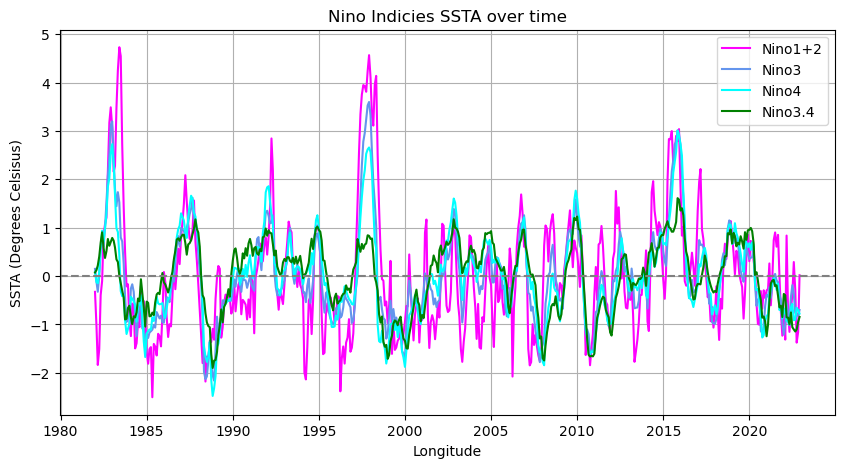

In [5]:
SST_detrend = detrend(ds_oiv2['sst'], 'time', deg=1)

SST_filt = SST_detrend 

# group a DataArray called 'sst' by month and calculate the average monthly values (i.e., the climatology)
sst_clim = SST_filt.groupby(SST_filt['time'].dt.month).mean()

monthly_sst = SST_filt.groupby(SST_filt['time'].dt.month)

ssta = monthly_sst - sst_clim


# calculate average SST for the whole tropical Pacific (here sst is a DataArray)
Nino12 = ssta.where((ssta.lat >= -5) & (ssta.lat <= 0 ) & 
                     (ssta.lon >= 270) & (ssta.lon <= 280), 
                     drop = True).mean(dim=['lat','lon'])

Nino3 = ssta.where((ssta.lat >= -5) & (ssta.lat <= 5 ) & 
                     (ssta.lon >= 210) & (ssta.lon <= 270), 
                     drop = True).mean(dim=['lat','lon'])

Nino34 = ssta.where((ssta.lat >= -5) & (ssta.lat <= 5 ) & 
                     (ssta.lon >= 190) & (ssta.lon <= 240), 
                     drop = True).mean(dim=['lat','lon'])

Nino4 = ssta.where((ssta.lat >= -5) & (ssta.lat <= 5 ) & 
                     (ssta.lon >= 160) & (ssta.lon <= 210), 
                     drop = True).mean(dim=['lat','lon'])

#plot
plt.figure(figsize=(10, 5))
plt.plot(ssta['time'], Nino12, color='magenta', label='Nino1+2')
plt.plot(ssta['time'], Nino3, color= 'cornflowerblue', label='Nino3')
plt.plot(ssta['time'], Nino34, color= 'cyan', label='Nino4')
plt.plot(ssta['time'], Nino4, color='green', label='Nino3.4')

plt.title('Nino Indicies SSTA over time')
plt.xlabel('Longitude')
plt.ylabel('SSTA (Degrees Celsisus)')
plt.grid(True)
plt.legend()
plt.axhline(y=0, color='gray', linestyle='--')

plt.savefig('NinoIndiciesSSTA.png', dpi=300, bbox_inches='tight')

plt.show()

In [6]:
#Standard Deviations
std_Nino12 = np.std(Nino12)
print(std_Nino12)
std_Nino3 = np.std(Nino3)
print(std_Nino3)
std_Nino34 = np.std(Nino34)
print(std_Nino34)
std_Nino4 = np.std(Nino4)
print(std_Nino4)

<xarray.DataArray ()>
array(1.27361208)
<xarray.DataArray ()>
array(0.95428939)
<xarray.DataArray ()>
array(0.93896636)
<xarray.DataArray ()>
array(0.72068656)


a) Both qualitatively and quantitatively, how do the four indices compare to one another in terms of their amplitude of SST variability (e.g., standard deviation)?

Nino 1+2 has the largest std. out of the 4 Nino Indicies with a std. of ~1.2 degrees Celsius followed by Nino3 and Nino3.4 with stds of ~0.95 and Nino 4 with a std. of ~0.72. This means that Nino1+2 has the largest amplitude of SST variability.


In [7]:
ssta

<xarray.DataArray (time: 492, lat: 180, lon: 360)>
array([[[ 1.00732431e-15,  1.00732431e-15,  1.00732431e-15, ...,
          1.00732431e-15,  1.00732431e-15,  1.00732431e-15],
        [ 1.00732431e-15,  1.00732431e-15,  1.00732431e-15, ...,
          1.00732431e-15,  1.00732431e-15,  1.00732431e-15],
        [-8.88059342e-03, -1.20191886e-02, -1.28206462e-02, ...,
         -9.68848420e-03, -9.80033413e-03, -1.01705709e-02],
        ...,
        [ 1.00732431e-15,  1.00732431e-15,  1.00732431e-15, ...,
          1.00732431e-15,  1.00732431e-15,  1.00732431e-15],
        [ 1.00732431e-15,  1.00732431e-15,  1.00732431e-15, ...,
          1.00732431e-15,  1.00732431e-15,  1.00732431e-15],
        [ 1.00732431e-15,  1.00732431e-15,  1.00732431e-15, ...,
          1.00732431e-15,  1.00732431e-15,  1.00732431e-15]],

       [[ 1.01274003e-15,  1.01274003e-15,  1.01274003e-15, ...,
          1.01274003e-15,  1.01274003e-15,  1.01274003e-15],
        [ 1.01274003e-15,  1.01274003e-15,  1.01274003e-15, ...,
          1.01274003e-15,  1.01274003e-15,  1.01274003e-15],
        [-1.61976596e-02, -1.83606460e-02, -1.89182014e-02, ...,
         -8.95677758e-03, -9.06862751e-03, -9.19496210e-03],
...
        [-9.53167085e-16, -9.53167085e-16, -9.53167085e-16, ...,
         -9.53167085e-16, -9.53167085e-16, -9.53167085e-16],
        [-9.53167085e-16, -9.53167085e-16, -9.53167085e-16, ...,
         -9.53167085e-16, -9.53167085e-16, -9.53167085e-16],
        [-9.53167085e-16, -9.53167085e-16, -9.53167085e-16, ...,
         -9.53167085e-16, -9.53167085e-16, -9.53167085e-16]],

       [[-9.47751362e-16, -9.47751362e-16, -9.47751362e-16, ...,
         -9.47751362e-16, -9.47751362e-16, -9.47751362e-16],
        [-9.47751362e-16, -9.47751362e-16, -9.47751362e-16, ...,
         -9.47751362e-16, -9.47751362e-16, -9.47751362e-16],
        [ 5.22206032e-03,  4.70212244e-03,  4.04016681e-03, ...,
          7.49336434e-03,  7.60521427e-03,  7.48764665e-03],
        ...,
        [-9.47751362e-16, -9.47751362e-16, -9.47751362e-16, ...,
         -9.47751362e-16, -9.47751362e-16, -9.47751362e-16],
        [-9.47751362e-16, -9.47751362e-16, -9.47751362e-16, ...,
         -9.47751362e-16, -9.47751362e-16, -9.47751362e-16],
        [-9.47751362e-16, -9.47751362e-16, -9.47751362e-16, ...,
         -9.47751362e-16, -9.47751362e-16, -9.47751362e-16]]])
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2022-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

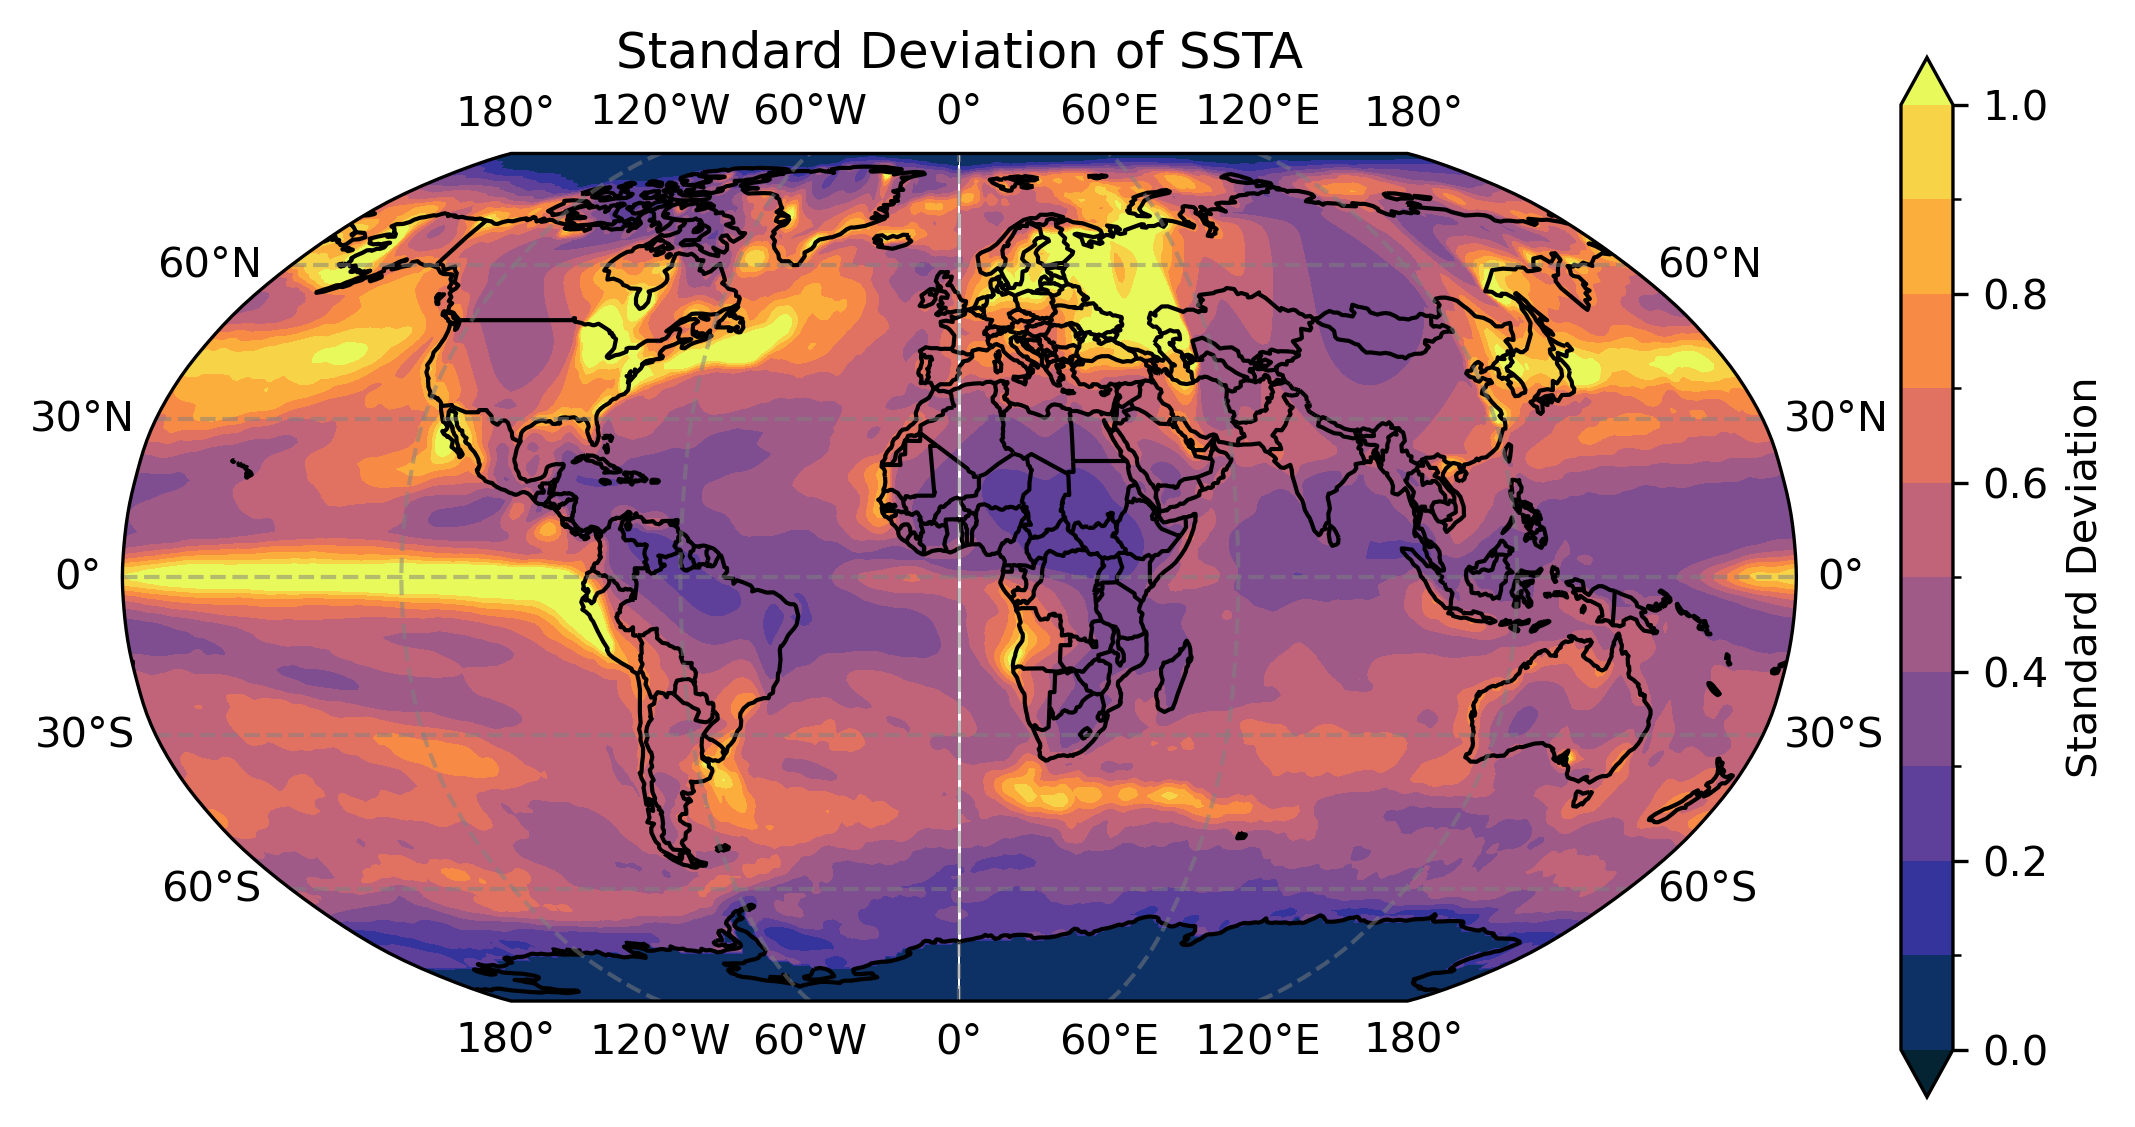

In [8]:
#STD Map
proj = ccrs.Robinson(central_longitude=0)
cmap = cmocean.cm.thermal
lev = np.arange(0, 1.10, 0.1)

fig = plt.figure(figsize=(9, 4.5), dpi=300)
ax = plt.axes(projection = proj)

# 
ssta.std(dim='time').plot.contourf(
    x='lon',
    y='lat',
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels=lev,
    extend='both',
    cmap=cmap,
    cbar_kwargs={'label': "Standard Deviation"}
    
 
)
# add coastlines
ax.add_feature(cfeature.BORDERS, linestyle ='None')
ax.coastlines(resolution='110m') 
ax.gridlines(crs = ccrs.PlateCarree(),
             draw_labels = True,
             linewidth = 1,
             color = 'gray',
             alpha = 0.5,
             linestyle = '--')

# add title
ax.set_title("Standard Deviation of SSTA")
fig.savefig('Standard Deviation of SSTA.png', facecolor = 'white', transparent = False, bbox_inches ='tight')

Does this confirm your results from part a?
Yes! We see that towards the Eastern Pacific (Nino1+2) there are higher std compared to the western Pacific (Nino4). 

In [9]:
P1 = scipy.stats.pearsonr(Nino12,Nino3)
print(P1)
P2 = scipy.stats.pearsonr(Nino12,Nino34)
print(P2)
P3 = scipy.stats.pearsonr(Nino12,Nino4)
print(P3)
P4 = scipy.stats.pearsonr(Nino3,Nino34)
print(P4)
P5 = scipy.stats.pearsonr(Nino3,Nino4)
print(P5)
P6 = scipy.stats.pearsonr(Nino34,Nino4)
print(P6)

PearsonRResult(statistic=0.8107302281262598, pvalue=5.085838565747246e-116)
PearsonRResult(statistic=0.6398892065531735, pvalue=5.0776173558933634e-58)
PearsonRResult(statistic=0.42326570192114216, pvalue=8.321174751173668e-23)
PearsonRResult(statistic=0.9429839065264317, pvalue=2.9945960884294656e-236)
PearsonRResult(statistic=0.7403842337092851, pvalue=1.4308977701826307e-86)
PearsonRResult(statistic=0.888810238431996, pvalue=3.6273811439932557e-168)


### Question 2 [12 points]: AMOC Variability
This question uses both the RAPID array and the NOAA ERSSTv5 data products.

**a.**	Using the RAPID 26°N array, plot the time series of 12-hour AMOC transport (variable: ‘moc_mar_hc10’). Overlay the 90-day smoothed AMOC transport (variable: ‘moc_mar_hc10_smooth90’) as a thicker line. Label all axes with appropriate units and add a title and legend. Include your plot in this document. 

**b.**	In what month and year did the strongest negative departure occur in the 90-day-smoothed AMOC transport time series? 

**c.** Using the NOAA ERSSTv5 dataset, calculate the climatology-removed SST anomalies. Then produce a global map of the SST anomalies during the month with the strongest negative AMOC departure determed in (b). Plot a horizontal line at 26.5°N representing the location of the RAPID array. Include your formatted map in this document.

**d.** Comment on the pattern of SST anomaly in the Atlantic basin, especially relative to the RAPID Array measurements (i.e., how do the SST anomalies compare north and south of 26.5°N?)

---
**Hints:**
- The `DataArray.argmin()` function will return the index of the minimum value of a DataArray
- This index can then be applied to the ERSSTv5 data

**Example code:**
```
# index for the minimum AMOC transport value (here for a DataArray called 'amoc')
minIdx = amoc.argmin()

# the time that corresponds with the the minimum AMOC transport value
timeMinAMOC = amoc['time'][minIdx]
```

In [10]:
filePath = '/Users/a_rust/Documents/EV353_Oceanography/rapid.nc'
ds_rapid = xr.open_dataset(filePath)
ds_rapid 

<xarray.Dataset>
Dimensions:                (time: 13779)
Coordinates:
  * time                   (time) datetime64[ns] 2004-04-02 ... 2023-02-11
Data variables:
    t_therm10              (time) float64 ...
    t_aiw10                (time) float64 ...
    t_ud10                 (time) float64 ...
    t_ld10                 (time) float64 ...
    t_bw10                 (time) float64 ...
    t_gs10                 (time) float64 ...
    t_ek10                 (time) float64 ...
    t_umo10                (time) float64 ...
    moc_mar_hc10           (time) float64 ...
    moc_mar_hc10_smooth90  (time) float64 ...
Attributes:
    Title:                         RAPID MOC timeseries
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/
    Acknowledgement:               The RAPID-MOC monitoring project is funded...
    Created_by:                    Ben Moat
    Creation_date:                 17-Sep-2024
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/223b34a32dc5c945e0637086abc0f...

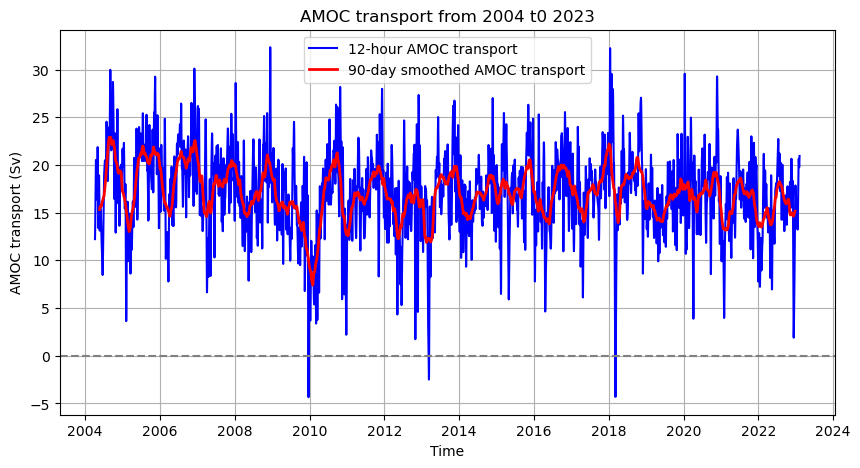

In [11]:
amoc12 = ds_rapid['moc_mar_hc10']
amoc90 = ds_rapid['moc_mar_hc10_smooth90']

#plot
plt.figure(figsize=(10, 5))
plt.plot(ds_rapid['time'], amoc12, color='blue', label='12-hour AMOC transport')
plt.plot(ds_rapid['time'], amoc90, color= 'red', label='90-day smoothed AMOC transport', linewidth=2)

plt.title('AMOC transport from 2004 t0 2023')
plt.xlabel('Time')
plt.ylabel('AMOC transport (Sv)')
plt.grid(True)
plt.legend()
plt.axhline(y=0, color='gray', linestyle='--')

plt.savefig('AMOCtransportlineplot.png', dpi=300, bbox_inches='tight')

plt.show()

In [12]:
#finding lowest value
minIdx = amoc90.argmin()
minamoc = amoc90['time'][minIdx]
print(minamoc)

<xarray.DataArray 'time' ()>
array('2010-02-01T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-02-01T12:00:00
Attributes:
    long_name:  time in days


b. In what month and year did the strongest negative departure occur in the 90-day-smoothed AMOC transport time series?
The strongest negative departure in the 90-day-smoothed AMOC time series occurs in february of 2010. 

In [13]:
sstafeb2010 = ssta.sel(time='2010-02-01T12:00:00.000000000', method='nearest')

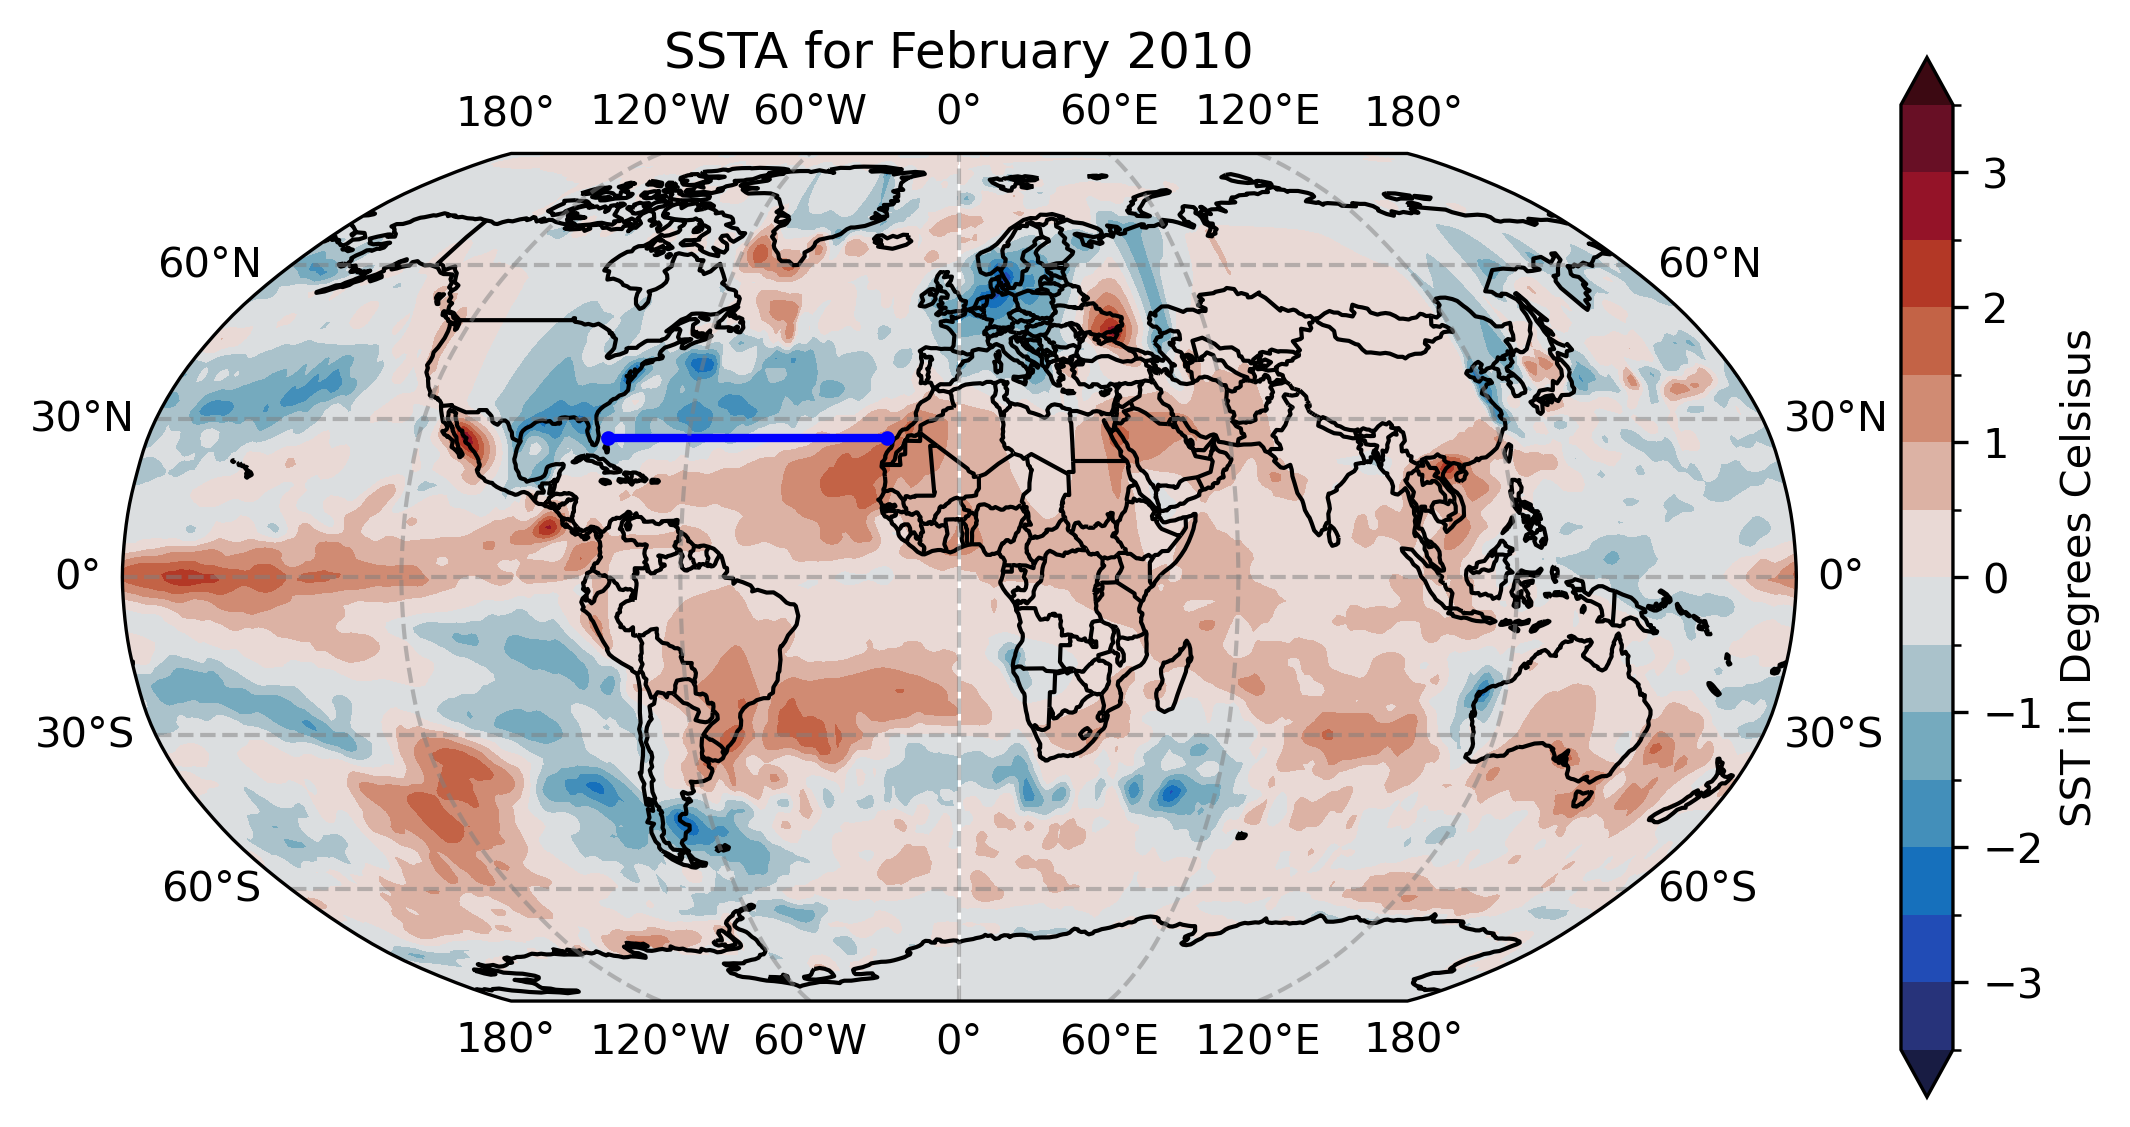

In [14]:
proj = ccrs.Robinson(central_longitude=0)
cmap = cmocean.cm.balance
lev = np.arange(-3.5, 4.00, 0.5)

fig = plt.figure(figsize=(9, 4.5), dpi=300)
ax = plt.axes(projection = proj)

sstafeb2010.plot.contourf(
    x='lon',
    y='lat',
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels=lev,
    extend='both',
    cmap=cmap,
    cbar_kwargs={'label': "SST in Degrees Celsisus"}
     
)
# add coastlines
ax.add_feature(cfeature.BORDERS, linestyle ='None')
ax.coastlines(resolution='110m') 
ax.gridlines(crs = ccrs.PlateCarree(),
             draw_labels = True,
             linewidth = 1,
             color = 'gray',
             alpha = 0.5,
             linestyle = '--')

ax.plot([282, 344], [26.5, 26.5], color='blue', linewidth=2, marker='.',
        transform=ccrs.PlateCarree(), markersize=5)

# add title
ax.set_title("SSTA for February 2010")
fig.savefig('SSTA for February 2010.png', facecolor = 'white', transparent = False, bbox_inches ='tight')

d. SSTA north of the RAPID array are relatively cooler comapred to the SSTA south of the RAPID array. Since AMOC during this time stamp is negative this indicates a southward movement of water, which is opposite the normal positive flow of AMOC. The movement of the cold water above the RAPID from it's normal location farther North is indicative of this change in sign of AMOC.

### Canvas Submission

Work closely with your partner to ensure your answers reflect your joint understanding of the material. 

**To submit your lab:**
1. Re-run the whole Notebook and check there are no errors
2. Submit your Jupyter Notebook (LastName_FirstName_EV353_PS3.ipynb) on Canvas (1 submission per person).
3. Compile your group's written responses and all the figures you generated in a separate Word or Google document. Export the document as a PDF and upload it to Canvas (1 submission per group).